### **Loading Used Libriries**

In [1]:
import numpy as np # linear algebra
import numpy.matlib
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from PIL import Image
import cv2
import random
import os ## handle files
import torch ## PyTorch
import torch.nn as nn ## Neural networks package
from torch import optim ## optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import models ## package consists of popular datasets, model architectures, and common image transformations for computer vision.
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
import torchvision.transforms as transforms ## for data augmentation
from sklearn.model_selection import train_test_split ## to split datasets
import seaborn as sns ## data plot
from sklearn.metrics import confusion_matrix ## plot the confusion matrix


# Setting the random seed for reproducibility
seed = 77
np.random.seed(seed) ## for numpy
torch.manual_seed(seed) ## for PyTorch
torch.cuda.manual_seed(seed)
random.seed(24) ## for random module on python


# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU is not available.")
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## use gpu if its available

GPU is available.
Number of GPUs available: 1
GPU 0: Tesla P100-PCIE-16GB


#### **Using Weights and Biases to Track the Models' Development**

In [2]:
!pip install wandb -qU ## install wandb

# Log in to your W&B account
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **1 - EDA of HAM10000 Dataset**

##### **1.1 - Loading Data**

In [3]:
## Path to data
HAM1000_path = '/kaggle/input/skin-cancer-mnist-ham10000/'

## to map the class acronym to its real name, according to the paper of the dataset
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

## collecting image paths
all_image_path = glob(os.path.join(HAM1000_path, '*', '*.jpg'))

## imageid_path_dict will map each image ID (the file name without the extension) to its full file path.
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}


df_original = pd.read_csv(os.path.join(HAM1000_path, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

## class names
classes = df_original['dx'].unique()

df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


##### **1.2 - Data Distribution**

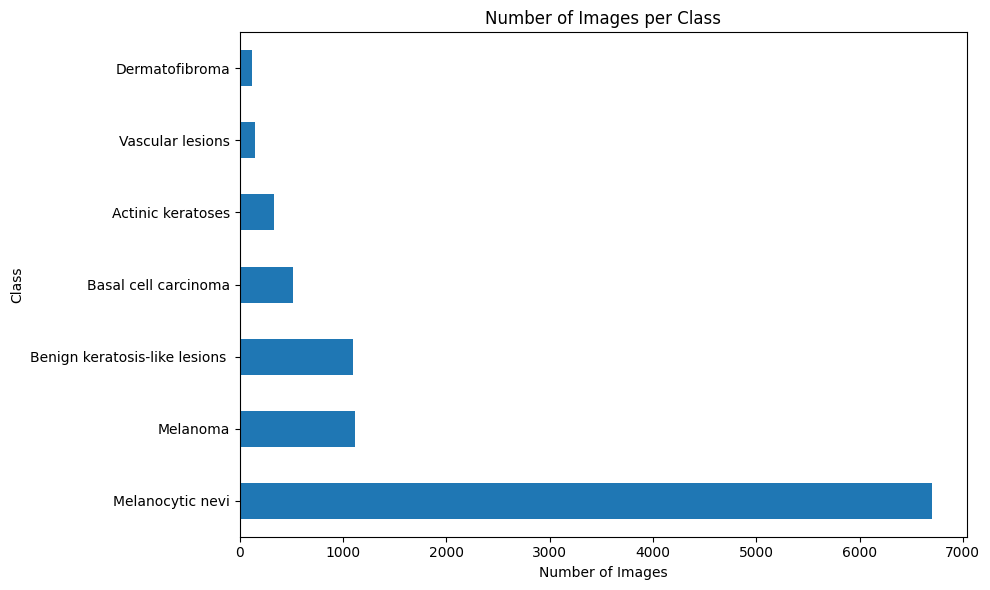

cell_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64


In [4]:
# Count the number of images in each class
class_counts = df_original['cell_type'].value_counts()

# Plot a histogram
plt.figure(figsize=(10, 6))
class_counts.plot(kind='barh')

# Add title and labels
plt.title('Number of Images per Class')
plt.ylabel('Class')
plt.xlabel('Number of Images')

# Display the plot
plt.tight_layout()
plt.show()


print(class_counts)

#### We have a clearly prevalence of the Melanocytic nevi class but, more generally, it is possible to notice an imbalance of the classes samples.

##### **1.3 Samples Example**

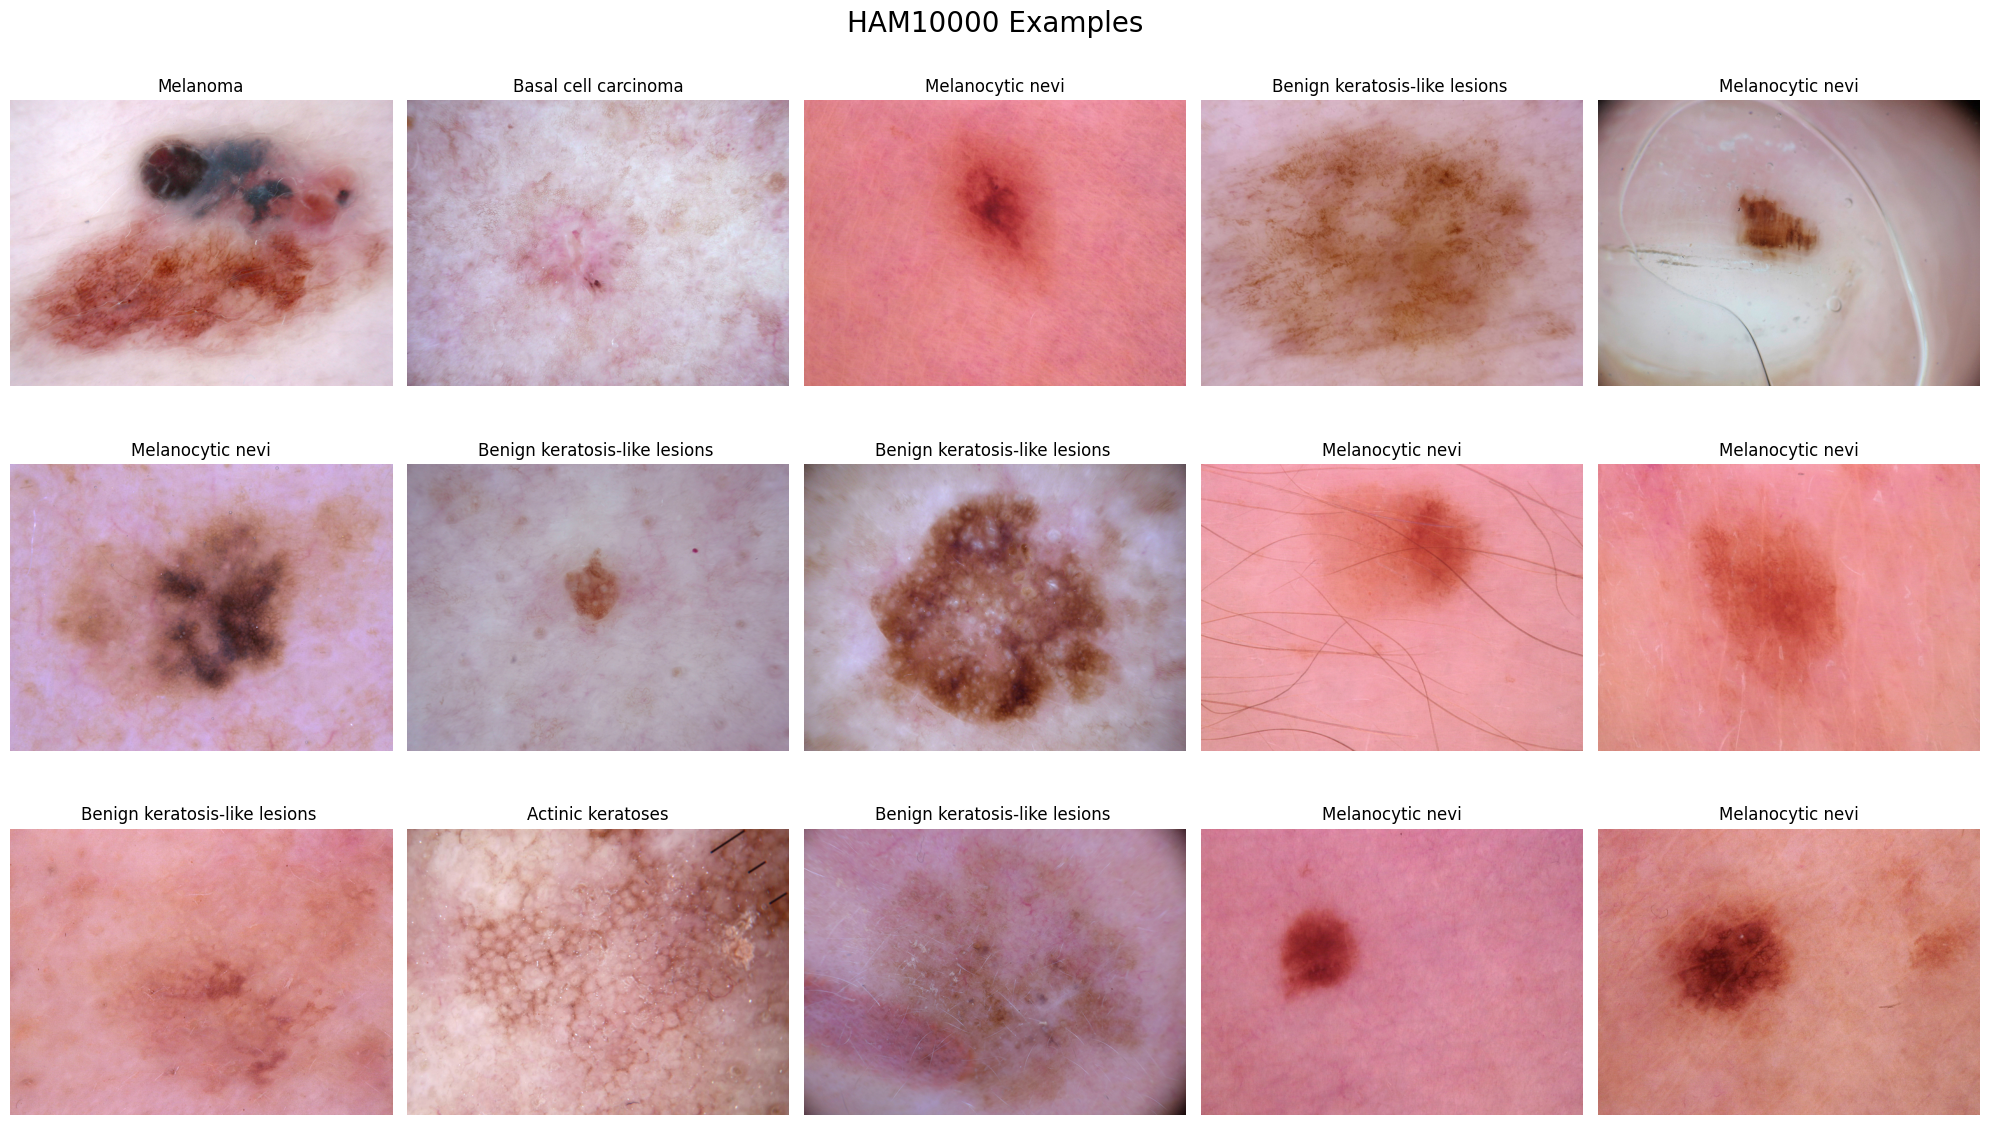

CPU times: user 4.14 s, sys: 215 ms, total: 4.36 s
Wall time: 4.21 s


In [5]:
%%time
## Showing some examples of the data

# Randomly select 15 rows from the dataframe
sample_df = df_original.sample(n=15)

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = row['path']
    cell_type = row['cell_type']
    
    # Open the image
    img = Image.open(img_path)
    
    # Display the image on the axis
    ax.imshow(img)
    ax.set_title(cell_type)
    ax.axis('off')  # Hide the axes ticks

# Add a main title for the whole plot
plt.suptitle('HAM10000 Examples', fontsize=20)
# Adjust the layout
plt.tight_layout()
plt.show()


### **2 - Data Pre-processing**

##### **2.1 - Useful Functions**

In [40]:
## Plots the Train/Val curves (Losses and Main Metric) 
def plot_history(train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist, model_name):
    epochs = range(1, len(train_loss_hist) + 1)
    
    # Plotting the loss history
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_hist, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss_hist, 'ro-', label='Validation Loss')
    plt.title(f'Training and Validation Loss: {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_hist, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, 'ro-', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy: {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1)  # Set y-axis limit from 0.4 to 1
    plt.grid()
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
## Plots the confusion matrix given a prediction and target labels
def plot_confusion_matrix(all_predictions, all_labels, num_classes, model_name):
    '''Plot the confusion matrix using predictions and true labels'''
    cm = confusion_matrix(all_labels.cpu().numpy(), all_predictions.cpu().numpy())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

    
## gets the mean and std from a given dataset
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = 120, 120
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

## Define the custom dataset class
class CustomHAM10000(Dataset):
    def __init__(self, dataframe, img_size, transform=None):
        self.paths = dataframe['path'].values
        self.labels = torch.tensor(dataframe['cell_type_idx'].values, dtype=torch.long)
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


##### **2.2 - Split Data**

In [7]:
## Setting Hyperparameters 

img_size = (120,120)  ## Used by https://arxiv.org/pdf/2303.07520
batch_size = 32  ## Default
random_state = seed

In [8]:
## separates between training (full and reduced), validation (the reference paper doesnt use test set)
df_train_val, df_test = train_test_split(df_original, test_size=0.11, stratify=df_original['dx'], random_state=random_state)
df_train, df_val = train_test_split(df_train_val, test_size=0.2, stratify=df_train_val['dx'], random_state=random_state)
df_train_small, _ = train_test_split(df_train, train_size=0.35, stratify=df_train['dx'], random_state=random_state)


## see datasets infos
print('-'*30)
print('datasets division')
print('-'*30)
print(f'Nº train (small) = {len(df_train_small)}')
print(f'Nº train (full)  = {len(df_train)}')
print(f'Nº val           = {len(df_val)}')
print(f'Nº test          = {len(df_test)}')

------------------------------
datasets division
------------------------------
Nº train (small) = 2495
Nº train (full)  = 7130
Nº val           = 1783
Nº test          = 1102


#### The test_size was chosen to match the number of samples present on the validation set present on: https://ieeexplore.ieee.org/document/10020302.

In [9]:
print(df_train['cell_type'].value_counts())
print('-'*40)
print(df_train_small['cell_type'].value_counts())
print('-'*40)
print(df_val['cell_type'].value_counts())
print('-'*40)
print(df_test['cell_type'].value_counts())
print('-'*40)

cell_type
Melanocytic nevi                  4773
Melanoma                           793
Benign keratosis-like lesions      782
Basal cell carcinoma               366
Actinic keratoses                  233
Vascular lesions                   101
Dermatofibroma                      82
Name: count, dtype: int64
----------------------------------------
cell_type
Melanocytic nevi                  1670
Melanoma                           277
Benign keratosis-like lesions      274
Basal cell carcinoma               128
Actinic keratoses                   82
Vascular lesions                    35
Dermatofibroma                      29
Name: count, dtype: int64
----------------------------------------
cell_type
Melanocytic nevi                  1194
Melanoma                           198
Benign keratosis-like lesions      196
Basal cell carcinoma                92
Actinic keratoses                   58
Vascular lesions                    25
Dermatofibroma                      20
Name: count, dtyp

#### In order to evaluate the model realistically, the validation set will also present an imbalance. We define a small dataset to test different hyperparameters and techniques with time efficiency.

##### **2.3 - Data Augmentation**

In [10]:
%%time
## Applying data augmentation on the whole dataset

## getting the mean and std from the training data
mean_train, std_train = compute_img_mean_std(np.array(df_train['path']))
#mean_train_small, std_train_small = compute_img_mean_std(np.array(df_train_small['path']))

100%|██████████| 7130/7130 [01:42<00:00, 69.64it/s]


(120, 120, 3, 7130)
normMean = [0.76365924, 0.54541785, 0.569591]
normStd = [0.14131476, 0.15196308, 0.1694385]
CPU times: user 45.1 s, sys: 3.34 s, total: 48.4 s
Wall time: 1min 45s


In [11]:
## ZCA Whitening Transformation Function

def zca_transform(batch_imgs, dtype=torch.float32):
    '''Apply the ZCA img Whitening for a given batch of images passed as tensors'''
    
    X = batch_imgs.numpy()
    
    X_flattened = X.reshape(X.shape[0], -1) ## flatten the tensor to have shape (n_samples, n_features)
    
    # compute the covariance of the image data
    cov = np.cov(X_flattened, rowvar=True)   # cov is (N, N)
    # singular value decomposition
    U,S, _ = np.linalg.svd(cov)     # U is (N, N), S is (N,)
    # build the ZCA matrix
    epsilon = 1e-5 ## factor, avoids 0 division (the highest, the low the ZCA factor)
    zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
    # transform the image data       zca_matrix is (N,N)
    zca = np.dot(zca_matrix, X_flattened)    # zca is (N, CxWxH)
    
    zca = zca.reshape(X.shape) ## Gets back to the original shape
    
    return torch.from_numpy(zca).to(dtype)  # Ensure the dtype is consistent with the model parameters
    

In [12]:
## Configuring transformer that will perform the Data Augmentation

## transformations to the augmented data (some values: https://arxiv.org/pdf/2101.03814v1)
transform_train = transforms.Compose([
                        transforms.RandomRotation(20), transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),
                        transforms.RandomAffine(degrees=0, translate=(0.1,0.1)), ##random width height shift
                        transforms.RandomResizedCrop(img_size, scale=(0.7, 1)), ##random zoom
                        transforms.Resize(img_size),
                        transforms.ToTensor(), transforms.Normalize(mean_train, std_train)])

## transformations for the rest of the data
transform_val = transforms.Compose([transforms.Resize(img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean_train, std_train)])

##### **2.4 - Creating the Datasets**

In [13]:
## Creates the datasets

## train_small_dataset
#train_data_small = ConcatDataset([lowprev_classes_augmented, highprev_class_data])
#ds_train_small = DataLoader(train_data_small, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

## train_dataset
train_data = CustomHAM10000(df_train, img_size, transform=transform_train)
ds_train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


## val_dataset
val_data = CustomHAM10000(df_val, img_size, transform=transform_val)
ds_val = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True) ## Shuffle = False (Reproducibility)


## test_dataset
test_data = CustomHAM10000(df_test, img_size, transform=transform_val)
ds_test = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#### Now, we applied data augmentation to the classes with lower prevalence and created the datasets that the models will be trained and tested on. It is important to notice that the data is normalized, which is a good practice since it enhances performance. The Data Augmentation technique should reduce (but not eliminate) the imbalance problem that we detected earlier in our analysis.

### **3 - Models' Experiments**

##### **3.1 - Importing Pretrained ImageNet Models**

In [14]:
## Function to load the models

def initialize_net_arch(model_name, num_classes, input_size, use_pretrained = True):
    
    ## stores the feature extractor of the selected model
    model_backbone = None
    
    
    if model_name == 'vgg16':
        
        model_backbone = models.vgg16(pretrained=True)
        #set_parameter_requires_grad(model_ft, feature_extract) ## for fine tunning
        
        ## new FC layer
        num_ftrs = model_backbone.classifier[6].in_features
        model_backbone.classifier[6] = nn.Sequential(
            nn.Linear(num_ftrs, 1024), ## dense layer (output 1/4 of the input, 4096)
            nn.ReLU(), ## relu activation
            nn.Dropout(p=0.4), ## dropout with p probability
            nn.Linear(1024, num_classes)
            #nn.Softmax(dim=1) ## softmax activation (no need because of the loss used CrossEntropy)
        )
    
    
    elif model_name == 'resnet50':
        
        model_backbone = models.resnet50(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_backbone, feature_extract) ## for fine tuning
        
        ## new FC layer
        num_ftrs = model_backbone.fc.in_features
        model_backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024), ## dense layer (output 1/2 of the input, 2048)
            nn.ReLU(), ## relu activation
            nn.Dropout(p=0.4), ## dropout with p probability
            nn.Linear(1024, num_classes)
        )
    
    
    
    elif model_name == 'inceptionV3':
        '''Beware, the InceptionV3 uses Nx3x299x299 inputs, so you must resize your images to match that'''
        model_backbone = models.inception_v3(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_backbone, feature_extract) ## for fine tuning
        
        ## new FC layer
        
        ## handle the auxilary net
        num_ftrs = model_backbone.AuxLogits.fc.in_features
        model_backbone.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        
        ## handle the primary net
        num_ftrs = model_backbone.fc.in_features
        model_backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 4096), ## dense layer
            nn.ReLU(), ## relu activation
            nn.Dropout(p=0.4), ## dropout with p probability
            nn.Linear(4096, num_classes)
        )
    
    elif model_name == 'densenet':
        ## choosing the 161 model because it's closer to the inception performance on the ImageNet dataset
        
        model_backbone = models.densenet161(pretrained=use_pretrained)
        
        ## new FC layer
        num_ftrs = model_backbone.classifier.in_features
        model_backbone.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1104), ## dense layer (output with 1/2 of the input, 2208)
            nn.ReLU(), ## relu activation
            nn.Dropout(p=0.4), ## dropout with p probability
            nn.Linear(1104, num_classes)
        )
        
        
    
    else:
        print("Model name not listed, exiting...\n\n")
        exit()
        
    
    return model_backbone
    

In [15]:
## Setting some parameters

## Used by https://arxiv.org/pdf/2303.07520
criterion = nn.CrossEntropyLoss()
epochs = 50 ## paper uses 30
num_classes = 7

##### **3.2 - Defining the Metrics Used**

In [16]:
## Functions of the metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc


## Accuracy function
def calculate_accuracy(predictions, labels):
    correct = (predictions == labels).sum().item()
    total = labels.size(0)
    return correct / total

## Normalized Multi-class Accuracy function  (Ref -> https://challenge.isic-archive.com/landing/2019/)
def normalized_multiclass_accuracy(predictions, labels, num_classes):
    recall_per_class = []
    
    for i in range(num_classes):
        true_positives = ((predictions == i) & (labels == i)).sum().item()
        total_positives = (labels == i).sum().item()
        
        if total_positives > 0:
            recall_per_class.append(true_positives / total_positives)
        else:
            recall_per_class.append(0.0)
    
    normalized_accuracy = sum(recall_per_class) / num_classes
    return normalized_accuracy

## Funcion that calculates the remaining metrics
def calculate_other_metrics(predictions, labels):
    precision = precision_score(labels.cpu(), predictions.cpu(), average='weighted')
    recall = recall_score(labels.cpu(), predictions.cpu(), average='weighted')
    f1 = f1_score(labels.cpu(), predictions.cpu(), average='weighted')
    
    # Compute ROC curve and AUC for each class
    num_classes = len(torch.unique(labels))
    fpr = []
    tpr = []
    roc_auc = []
    for class_idx in range(num_classes):
        class_labels = (labels.cpu() == class_idx)
        class_predictions = (predictions.cpu() == class_idx)
        fpr_i, tpr_i, _ = roc_curve(class_labels, class_predictions, pos_label=1)
        roc_auc_i = auc(fpr_i, tpr_i)
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        roc_auc.append(roc_auc_i)
    
    # Calculate macro-average AUC
    macro_auc = sum(roc_auc) / num_classes
    
    return precision, recall, f1, macro_auc

##### **3.3 - Defining the Training/Evalutation Loop**

In [17]:
## Create directory to store the models' checkpoints

os.makedirs('/kaggle/working/models', exist_ok=True)

In [18]:
## Training epoch function
def train_epoch(model, optimizer, data_loader, loss_criterion, num_classes):
    '''Train a Neural Network for one epoch'''
    dev = next(model.parameters()).device ## gets where the model is alocated
    model.train() ## tells that we're training so Dropout, etc will be active.
    
    running_loss = 0
    all_predictions = []
    all_labels = []
    
    for images, labels in tqdm(data_loader):
        
        whitened_imgs = zca_transform(images, dtype=images.dtype)
        
        images, labels = whitened_imgs.to(dev), labels.to(dev)
        optimizer.zero_grad() ## cleans the gradient tensor (it accumulates)
        output = model(images) ## get prediction of the model
        loss = loss_criterion(output, labels) ## calculate loss
        loss.backward() ## backprop to obtain the influence of the weights on the loss func
        optimizer.step() ## updates the weights
        
        running_loss += loss.item() ## accumulates the loss to calculate the average loss.
        
        _, predicted = torch.max(output, 1)
        all_predictions.append(predicted)
        all_labels.append(labels)
    
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    accuracy = calculate_accuracy(all_predictions, all_labels)
    normalized_accuracy = normalized_multiclass_accuracy(all_predictions, all_labels, num_classes)
    
    return running_loss / len(data_loader), accuracy, normalized_accuracy

## Evaluation function
def evaluate(model, data_loader, loss_criterion, num_classes):
    '''Evaluate the model on the validation set'''
    dev = next(model.parameters()).device
    model.eval() ## tells that we're evalutating the model, so we don't use Dropout layers, etc
    
    running_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            
            whitened_imgs = zca_transform(images, dtype=images.dtype)
        
            images, labels = whitened_imgs.to(dev), labels.to(dev)
            
            output = model(images)
            loss = loss_criterion(output, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(output, 1) ## gets the predicted class with the highest probability (MSP).
            all_predictions.append(predicted)
            all_labels.append(labels)
    
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    accuracy = calculate_accuracy(all_predictions, all_labels)
    normalized_accuracy = normalized_multiclass_accuracy(all_predictions, all_labels, num_classes)
    
    return running_loss / len(data_loader), accuracy, normalized_accuracy, all_predictions, all_labels


## Training loop function
def train_loop(model, optimizer, scheduler, criterion, train_loader, val_loader, epochs, num_classes, model_name):
    
    best_val_acc = 0
    best_val_acc_epoch = 1
    
    train_loss_hist = []
    val_loss_hist = []
    
    train_acc_hist = []
    val_acc_hist = []
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        train_loss, train_accuracy, train_normalized_accuracy = train_epoch(model, optimizer, train_loader, criterion, num_classes)
        val_loss, val_accuracy, val_normalized_accuracy, val_predictions, val_labels = evaluate(model, val_loader, criterion, num_classes)
        scheduler.step(val_accuracy) ## updates based on the val_acc
        
        print(f"Training Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Normalized Accuracy: {train_normalized_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Normalized Accuracy: {val_normalized_accuracy:.4f}")
        print(f'Learning Rate Value: {optimizer.param_groups[0]["lr"]}')
        
        print('--'*50)
        
        ## track losses
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        ## track acc
        train_acc_hist.append(train_accuracy)
        val_acc_hist.append(val_accuracy)
        
        ## track with wandb
        wandb.log({'epoch':epoch, 'train_loss':train_loss, 'val_loss':val_loss, 'train_acc':train_accuracy,
                   'val_acc':val_accuracy, 'learning rate': optimizer.param_groups[0]["lr"]})
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_val_acc_epoch = epoch
            
            torch.save(model.state_dict(), f'/kaggle/working/models/{model_name}_best_acc.pth')
    
    print(f'Best Results at epoch {best_val_acc_epoch}. Val Accuracy = {best_val_acc}\n\n\n')
    
    return val_predictions, val_labels, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

##### **3.4 - Training and Evaluation of Models**

In [30]:
## Instantiating the models

vgg16 = initialize_net_arch('vgg16', num_classes, img_size, use_pretrained = True)

resnet50 = initialize_net_arch('resnet50', num_classes, img_size, use_pretrained = True)

densenet = initialize_net_arch('densenet', num_classes, img_size, use_pretrained = True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
 

In [21]:
## Setting the optimizer to each network

## Used by https://arxiv.org/pdf/2303.07520

optimizer_vgg16 = optim.Adam(vgg16.parameters(), lr=0.0001, weight_decay=0.00001)
optimizer_resnet50 = optim.Adam(resnet50.parameters(), lr=0.0001, weight_decay=0.00001)
optimizer_densenet = optim.Adam(densenet.parameters(), lr=0.0001, weight_decay=0.00001) ## lr=0.001 (paper)


## Setting a Lr Scheduler so it decreases the lr if the metric doesn't improve (in X epochs)

## max because our main metric is the val_acc
scheduler_vgg16 = lr_scheduler.ReduceLROnPlateau(optimizer_vgg16, mode='max', factor=0.1, patience=10) ## max because our main metric is the val_acc
scheduler_resnet50 = lr_scheduler.ReduceLROnPlateau(optimizer_resnet50, mode='max', factor=0.1, patience=10)
scheduler_densenet = lr_scheduler.ReduceLROnPlateau(optimizer_densenet, mode='max', factor=0.1, patience=10)

In [24]:
%%time
## Training/Evaluating on validation set vgg16

## set model to devide
vgg16 = vgg16.to(device)

wandb.init(
      # Set the project where this run will be logged
      project="HAM_IMG_Classifier", 
      # We pass a run name
      name=f"base-vgg16", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0001,
      "architecture": "Vgg16",
      "dataset": "HAM10K",
      "epochs": epochs,
      "criterion": criterion,
      "weight decay" : 0.00001,
          "scheduler": "True"
      })

##small
#vgg16_val_predictions, vgg16_val_labels, vgg16_train_loss_hist, vgg16_val_loss_hist, vgg16_train_acc_hist, vgg16_net_val_acc_hist = train_loop(vgg16, optimizer_vgg16, criterion, ds_train_small, ds_val, epochs, num_classes, 'vgg16')
##full
vgg16_val_predictions, vgg16_val_labels, vgg16_train_loss_hist, vgg16_val_loss_hist, vgg16_train_acc_hist, vgg16_net_val_acc_hist = train_loop(vgg16, optimizer_vgg16, scheduler_vgg16, criterion, ds_train, ds_val, epochs, num_classes, 'base_vgg16')

# Mark the run as finished
wandb.finish()

wandb: Currently logged in as: pedrocast7 (projects-pedro-ml). Use `wandb login --relogin` to force relogin


Epoch 1/50


100%|██████████| 56/56 [00:11<00:00,  4.86it/s]


Training Loss: 0.9419, Train Accuracy: 0.6792, Train Normalized Accuracy: 0.1968
Validation Loss: 1.0934, Val Accuracy: 0.5541, Val Normalized Accuracy: 0.3016
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 2/50


100%|██████████| 56/56 [00:09<00:00,  6.10it/s]


Training Loss: 0.7907, Train Accuracy: 0.7114, Train Normalized Accuracy: 0.3532
Validation Loss: 1.0011, Val Accuracy: 0.6736, Val Normalized Accuracy: 0.4338
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 3/50


100%|██████████| 56/56 [00:09<00:00,  5.95it/s]


Training Loss: 0.7440, Train Accuracy: 0.7342, Train Normalized Accuracy: 0.4008
Validation Loss: 1.0139, Val Accuracy: 0.6029, Val Normalized Accuracy: 0.4809
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 4/50


100%|██████████| 56/56 [00:08<00:00,  6.24it/s]


Training Loss: 0.6953, Train Accuracy: 0.7525, Train Normalized Accuracy: 0.4439
Validation Loss: 0.7728, Val Accuracy: 0.7358, Val Normalized Accuracy: 0.5051
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 5/50


100%|██████████| 56/56 [00:09<00:00,  5.92it/s]


Training Loss: 0.6572, Train Accuracy: 0.7648, Train Normalized Accuracy: 0.4859
Validation Loss: 0.7712, Val Accuracy: 0.7431, Val Normalized Accuracy: 0.5157
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 6/50


100%|██████████| 56/56 [00:08<00:00,  6.25it/s]


Training Loss: 0.6418, Train Accuracy: 0.7703, Train Normalized Accuracy: 0.5076
Validation Loss: 0.8853, Val Accuracy: 0.6915, Val Normalized Accuracy: 0.5635
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 7/50


100%|██████████| 56/56 [00:09<00:00,  5.83it/s]


Training Loss: 0.6234, Train Accuracy: 0.7808, Train Normalized Accuracy: 0.5224
Validation Loss: 1.0610, Val Accuracy: 0.5895, Val Normalized Accuracy: 0.4652
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 8/50


100%|██████████| 56/56 [00:09<00:00,  6.16it/s]


Training Loss: 0.5971, Train Accuracy: 0.7879, Train Normalized Accuracy: 0.5545
Validation Loss: 0.7975, Val Accuracy: 0.6938, Val Normalized Accuracy: 0.5253
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 9/50


100%|██████████| 56/56 [00:09<00:00,  6.14it/s]


Training Loss: 0.5851, Train Accuracy: 0.7931, Train Normalized Accuracy: 0.5632
Validation Loss: 0.6638, Val Accuracy: 0.7622, Val Normalized Accuracy: 0.6603
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 10/50


100%|██████████| 56/56 [00:09<00:00,  6.18it/s]


Training Loss: 0.5633, Train Accuracy: 0.7972, Train Normalized Accuracy: 0.5876
Validation Loss: 0.7230, Val Accuracy: 0.7420, Val Normalized Accuracy: 0.6548
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 11/50


100%|██████████| 56/56 [00:09<00:00,  5.99it/s]


Training Loss: 0.5499, Train Accuracy: 0.8072, Train Normalized Accuracy: 0.6175
Validation Loss: 0.7007, Val Accuracy: 0.7510, Val Normalized Accuracy: 0.6236
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 12/50


100%|██████████| 56/56 [00:09<00:00,  5.93it/s]


Training Loss: 0.5541, Train Accuracy: 0.8067, Train Normalized Accuracy: 0.5733
Validation Loss: 1.0420, Val Accuracy: 0.5805, Val Normalized Accuracy: 0.5774
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 13/50


100%|██████████| 56/56 [00:09<00:00,  6.05it/s]


Training Loss: 0.5157, Train Accuracy: 0.8102, Train Normalized Accuracy: 0.6193
Validation Loss: 0.8786, Val Accuracy: 0.6562, Val Normalized Accuracy: 0.5996
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 14/50


100%|██████████| 56/56 [00:09<00:00,  6.15it/s]


Training Loss: 0.5020, Train Accuracy: 0.8227, Train Normalized Accuracy: 0.6234
Validation Loss: 0.8033, Val Accuracy: 0.7078, Val Normalized Accuracy: 0.6473
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 15/50


100%|██████████| 56/56 [00:09<00:00,  6.04it/s]


Training Loss: 0.5022, Train Accuracy: 0.8199, Train Normalized Accuracy: 0.6437
Validation Loss: 0.6421, Val Accuracy: 0.7796, Val Normalized Accuracy: 0.5541
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 16/50


100%|██████████| 56/56 [00:09<00:00,  6.03it/s]


Training Loss: 0.4745, Train Accuracy: 0.8289, Train Normalized Accuracy: 0.6717
Validation Loss: 0.7789, Val Accuracy: 0.7145, Val Normalized Accuracy: 0.6472
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 17/50


100%|██████████| 56/56 [00:09<00:00,  6.11it/s]


Training Loss: 0.4697, Train Accuracy: 0.8279, Train Normalized Accuracy: 0.6691
Validation Loss: 0.6865, Val Accuracy: 0.7493, Val Normalized Accuracy: 0.6081
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 18/50


100%|██████████| 56/56 [00:08<00:00,  6.29it/s]


Training Loss: 0.4557, Train Accuracy: 0.8346, Train Normalized Accuracy: 0.6884
Validation Loss: 0.8341, Val Accuracy: 0.7084, Val Normalized Accuracy: 0.6213
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 19/50


100%|██████████| 56/56 [00:08<00:00,  6.23it/s]


Training Loss: 0.4393, Train Accuracy: 0.8394, Train Normalized Accuracy: 0.6975
Validation Loss: 0.7380, Val Accuracy: 0.7302, Val Normalized Accuracy: 0.6304
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 20/50


100%|██████████| 56/56 [00:09<00:00,  5.95it/s]


Training Loss: 0.4609, Train Accuracy: 0.8366, Train Normalized Accuracy: 0.6595
Validation Loss: 0.6558, Val Accuracy: 0.7667, Val Normalized Accuracy: 0.6784
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 21/50


100%|██████████| 56/56 [00:09<00:00,  6.09it/s]


Training Loss: 0.4079, Train Accuracy: 0.8562, Train Normalized Accuracy: 0.7193
Validation Loss: 0.6927, Val Accuracy: 0.7414, Val Normalized Accuracy: 0.6531
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 22/50


100%|██████████| 56/56 [00:09<00:00,  6.16it/s]


Training Loss: 0.4167, Train Accuracy: 0.8489, Train Normalized Accuracy: 0.7147
Validation Loss: 0.6467, Val Accuracy: 0.7813, Val Normalized Accuracy: 0.6613
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 23/50


100%|██████████| 56/56 [00:09<00:00,  6.05it/s]


Training Loss: 0.4001, Train Accuracy: 0.8546, Train Normalized Accuracy: 0.7301
Validation Loss: 0.6729, Val Accuracy: 0.7628, Val Normalized Accuracy: 0.6341
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 24/50


100%|██████████| 56/56 [00:09<00:00,  6.03it/s]


Training Loss: 0.3967, Train Accuracy: 0.8589, Train Normalized Accuracy: 0.7273
Validation Loss: 0.7195, Val Accuracy: 0.7431, Val Normalized Accuracy: 0.6476
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 25/50


100%|██████████| 56/56 [00:09<00:00,  6.21it/s]


Training Loss: 0.3808, Train Accuracy: 0.8635, Train Normalized Accuracy: 0.7276
Validation Loss: 0.6690, Val Accuracy: 0.7684, Val Normalized Accuracy: 0.6248
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 26/50


100%|██████████| 56/56 [00:09<00:00,  5.96it/s]


Training Loss: 0.3786, Train Accuracy: 0.8626, Train Normalized Accuracy: 0.7389
Validation Loss: 0.8240, Val Accuracy: 0.7263, Val Normalized Accuracy: 0.5441
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 27/50


100%|██████████| 56/56 [00:09<00:00,  6.14it/s]


Training Loss: 0.3648, Train Accuracy: 0.8662, Train Normalized Accuracy: 0.7465
Validation Loss: 0.6969, Val Accuracy: 0.7538, Val Normalized Accuracy: 0.6829
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 28/50


100%|██████████| 56/56 [00:09<00:00,  6.01it/s]


Training Loss: 0.3677, Train Accuracy: 0.8686, Train Normalized Accuracy: 0.7680
Validation Loss: 0.6785, Val Accuracy: 0.7684, Val Normalized Accuracy: 0.6776
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 29/50


100%|██████████| 56/56 [00:09<00:00,  6.14it/s]


Training Loss: 0.3662, Train Accuracy: 0.8672, Train Normalized Accuracy: 0.7520
Validation Loss: 0.6696, Val Accuracy: 0.7672, Val Normalized Accuracy: 0.6581
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 30/50


100%|██████████| 56/56 [00:08<00:00,  6.26it/s]


Training Loss: 0.3515, Train Accuracy: 0.8731, Train Normalized Accuracy: 0.7560
Validation Loss: 0.6703, Val Accuracy: 0.7801, Val Normalized Accuracy: 0.6806
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 31/50


100%|██████████| 56/56 [00:09<00:00,  6.08it/s]


Training Loss: 0.3319, Train Accuracy: 0.8788, Train Normalized Accuracy: 0.7631
Validation Loss: 0.9375, Val Accuracy: 0.6971, Val Normalized Accuracy: 0.6977
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 32/50


100%|██████████| 56/56 [00:09<00:00,  5.94it/s]


Training Loss: 0.3283, Train Accuracy: 0.8801, Train Normalized Accuracy: 0.7866
Validation Loss: 0.8477, Val Accuracy: 0.7100, Val Normalized Accuracy: 0.6334
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 33/50


100%|██████████| 56/56 [00:08<00:00,  6.31it/s]


Training Loss: 0.3334, Train Accuracy: 0.8790, Train Normalized Accuracy: 0.7772
Validation Loss: 0.6965, Val Accuracy: 0.7813, Val Normalized Accuracy: 0.6507
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 34/50


100%|██████████| 56/56 [00:08<00:00,  6.39it/s]


Training Loss: 0.2408, Train Accuracy: 0.9121, Train Normalized Accuracy: 0.8271
Validation Loss: 0.6574, Val Accuracy: 0.7936, Val Normalized Accuracy: 0.6946
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 35/50


100%|██████████| 56/56 [00:09<00:00,  6.21it/s]


Training Loss: 0.2187, Train Accuracy: 0.9165, Train Normalized Accuracy: 0.8433
Validation Loss: 0.7159, Val Accuracy: 0.7801, Val Normalized Accuracy: 0.6992
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 36/50


100%|██████████| 56/56 [00:09<00:00,  5.91it/s]


Training Loss: 0.1975, Train Accuracy: 0.9265, Train Normalized Accuracy: 0.8713
Validation Loss: 0.7550, Val Accuracy: 0.7846, Val Normalized Accuracy: 0.6822
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 37/50


100%|██████████| 56/56 [00:08<00:00,  6.22it/s]


Training Loss: 0.1975, Train Accuracy: 0.9282, Train Normalized Accuracy: 0.8697
Validation Loss: 0.7269, Val Accuracy: 0.8009, Val Normalized Accuracy: 0.7028
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 38/50


100%|██████████| 56/56 [00:08<00:00,  6.39it/s]


Training Loss: 0.1898, Train Accuracy: 0.9304, Train Normalized Accuracy: 0.8738
Validation Loss: 0.7249, Val Accuracy: 0.8009, Val Normalized Accuracy: 0.6679
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 39/50


100%|██████████| 56/56 [00:09<00:00,  6.04it/s]


Training Loss: 0.1799, Train Accuracy: 0.9334, Train Normalized Accuracy: 0.8809
Validation Loss: 0.7651, Val Accuracy: 0.7981, Val Normalized Accuracy: 0.6986
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 40/50


100%|██████████| 56/56 [00:08<00:00,  6.35it/s]


Training Loss: 0.1773, Train Accuracy: 0.9356, Train Normalized Accuracy: 0.8836
Validation Loss: 0.7716, Val Accuracy: 0.7975, Val Normalized Accuracy: 0.6960
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 41/50


100%|██████████| 56/56 [00:09<00:00,  6.18it/s]


Training Loss: 0.1747, Train Accuracy: 0.9342, Train Normalized Accuracy: 0.8945
Validation Loss: 0.7930, Val Accuracy: 0.7998, Val Normalized Accuracy: 0.6807
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 42/50


100%|██████████| 56/56 [00:08<00:00,  6.43it/s]


Training Loss: 0.1720, Train Accuracy: 0.9358, Train Normalized Accuracy: 0.8888
Validation Loss: 0.7930, Val Accuracy: 0.7964, Val Normalized Accuracy: 0.6982
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 43/50


100%|██████████| 56/56 [00:09<00:00,  6.01it/s]


Training Loss: 0.1667, Train Accuracy: 0.9391, Train Normalized Accuracy: 0.8992
Validation Loss: 0.7629, Val Accuracy: 0.8048, Val Normalized Accuracy: 0.6822
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 44/50


100%|██████████| 56/56 [00:08<00:00,  6.43it/s]


Training Loss: 0.1616, Train Accuracy: 0.9417, Train Normalized Accuracy: 0.9003
Validation Loss: 0.8313, Val Accuracy: 0.7970, Val Normalized Accuracy: 0.6977
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 45/50


100%|██████████| 56/56 [00:08<00:00,  6.41it/s]


Training Loss: 0.1570, Train Accuracy: 0.9419, Train Normalized Accuracy: 0.9035
Validation Loss: 0.8288, Val Accuracy: 0.8015, Val Normalized Accuracy: 0.6990
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 46/50


100%|██████████| 56/56 [00:08<00:00,  6.36it/s]


Training Loss: 0.1572, Train Accuracy: 0.9387, Train Normalized Accuracy: 0.9009
Validation Loss: 0.8494, Val Accuracy: 0.8003, Val Normalized Accuracy: 0.6871
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 47/50


100%|██████████| 56/56 [00:09<00:00,  5.96it/s]


Training Loss: 0.1554, Train Accuracy: 0.9424, Train Normalized Accuracy: 0.9023
Validation Loss: 0.9074, Val Accuracy: 0.7790, Val Normalized Accuracy: 0.7074
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 48/50


100%|██████████| 56/56 [00:08<00:00,  6.27it/s]


Training Loss: 0.1525, Train Accuracy: 0.9449, Train Normalized Accuracy: 0.9120
Validation Loss: 0.9293, Val Accuracy: 0.7785, Val Normalized Accuracy: 0.7005
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 49/50


100%|██████████| 56/56 [00:08<00:00,  6.27it/s]


Training Loss: 0.1479, Train Accuracy: 0.9433, Train Normalized Accuracy: 0.9009
Validation Loss: 0.8911, Val Accuracy: 0.8015, Val Normalized Accuracy: 0.6971
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 50/50


100%|██████████| 56/56 [00:08<00:00,  6.57it/s]


Training Loss: 0.1572, Train Accuracy: 0.9428, Train Normalized Accuracy: 0.8963
Validation Loss: 0.8700, Val Accuracy: 0.7858, Val Normalized Accuracy: 0.7062
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Best Results at epoch 42. Val Accuracy = 0.804823331463825





epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning rate,██████████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▇████████████
train_loss,█▇▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▂▆▅▂▅▇▆▂▄▅▅▆▅▆▆▇▇▆▆▇▇▇▅▅▇█▇████████▇▇▇
val_loss,█▇▇▃▅▇▃▁▂▇▅▃▃▂▄▂▂▁▁▂▄▂▁▁▆▄▂▁▃▂▂▃▃▃▃▄▄▅▅▄
epoch,49
learning rate,1e-05
train_acc,0.94278
train_loss,0.15722
val_acc,0.78575


CPU times: user 39min 33s, sys: 26min 19s, total: 1h 5min 52s
Wall time: 47min 45s


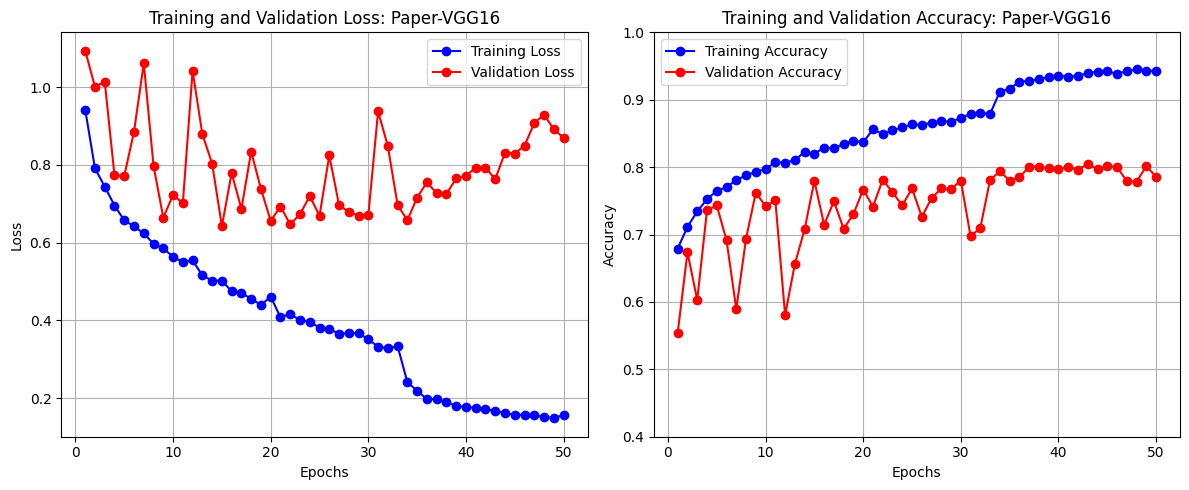

In [25]:
plot_history(vgg16_train_loss_hist, vgg16_val_loss_hist,
             vgg16_train_acc_hist, vgg16_net_val_acc_hist, 'Paper-VGG16')

In [26]:
%%time
## Training/Evaluating on validation set resnet50

## set model to devide
resnet50 = resnet50.to(device)

wandb.init(
      # Set the project where this run will be logged
      project="HAM_IMG_Classifier", 
      # We pass a run name
      name=f"base-resnet50", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0001,
      "architecture": "Resnet50",
      "dropout": 0.4,
      "dataset": "HAM10K",
      "epochs": epochs,
      "criterion": criterion,
      "weight decay" : 0.00001,
      "scheduler": "True"
      })


##small
#resnet50_val_predictions, resnet50_val_labels, resnet50_train_loss_hist, resnet50_val_loss_hist, resnet50_train_acc_hist, resnet50_net_val_acc_hist = train_loop(resnet50, optimizer_resnet50, criterion, ds_train_small, ds_val, epochs, num_classes, 'resnet50')
##full
resnet50_val_predictions, resnet50_val_labels, resnet50_train_loss_hist, resnet50_val_loss_hist, resnet50_train_acc_hist, resnet50_net_val_acc_hist = train_loop(resnet50, optimizer_resnet50, scheduler_resnet50, criterion, ds_train, ds_val, epochs, num_classes, 'base_resnet50')

# Mark the run as finished
wandb.finish()

Epoch 1/50


100%|██████████| 56/56 [00:09<00:00,  5.99it/s]


Training Loss: 0.8038, Train Accuracy: 0.7112, Train Normalized Accuracy: 0.2944
Validation Loss: 0.9906, Val Accuracy: 0.5996, Val Normalized Accuracy: 0.4189
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 2/50


100%|██████████| 56/56 [00:08<00:00,  6.39it/s]


Training Loss: 0.6494, Train Accuracy: 0.7648, Train Normalized Accuracy: 0.4858
Validation Loss: 0.7316, Val Accuracy: 0.7241, Val Normalized Accuracy: 0.5115
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 3/50


100%|██████████| 56/56 [00:08<00:00,  6.26it/s]


Training Loss: 0.6047, Train Accuracy: 0.7797, Train Normalized Accuracy: 0.5270
Validation Loss: 0.9114, Val Accuracy: 0.6455, Val Normalized Accuracy: 0.5725
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 4/50


100%|██████████| 56/56 [00:08<00:00,  6.36it/s]


Training Loss: 0.5696, Train Accuracy: 0.7924, Train Normalized Accuracy: 0.5733
Validation Loss: 0.7962, Val Accuracy: 0.7112, Val Normalized Accuracy: 0.5900
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 5/50


100%|██████████| 56/56 [00:09<00:00,  5.80it/s]


Training Loss: 0.5406, Train Accuracy: 0.8027, Train Normalized Accuracy: 0.6004
Validation Loss: 0.9053, Val Accuracy: 0.6399, Val Normalized Accuracy: 0.5729
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 6/50


100%|██████████| 56/56 [00:08<00:00,  6.56it/s]


Training Loss: 0.5030, Train Accuracy: 0.8226, Train Normalized Accuracy: 0.6428
Validation Loss: 0.7947, Val Accuracy: 0.6865, Val Normalized Accuracy: 0.6116
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 7/50


100%|██████████| 56/56 [00:08<00:00,  6.51it/s]


Training Loss: 0.4786, Train Accuracy: 0.8227, Train Normalized Accuracy: 0.6494
Validation Loss: 0.5941, Val Accuracy: 0.7869, Val Normalized Accuracy: 0.6354
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 8/50


100%|██████████| 56/56 [00:08<00:00,  6.25it/s]


Training Loss: 0.4594, Train Accuracy: 0.8356, Train Normalized Accuracy: 0.6758
Validation Loss: 0.6804, Val Accuracy: 0.7448, Val Normalized Accuracy: 0.6645
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 9/50


100%|██████████| 56/56 [00:09<00:00,  6.07it/s]


Training Loss: 0.4475, Train Accuracy: 0.8396, Train Normalized Accuracy: 0.6885
Validation Loss: 0.7762, Val Accuracy: 0.7117, Val Normalized Accuracy: 0.6667
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 10/50


100%|██████████| 56/56 [00:08<00:00,  6.64it/s]


Training Loss: 0.4402, Train Accuracy: 0.8428, Train Normalized Accuracy: 0.6905
Validation Loss: 0.8061, Val Accuracy: 0.6994, Val Normalized Accuracy: 0.6589
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 11/50


100%|██████████| 56/56 [00:08<00:00,  6.51it/s]


Training Loss: 0.4268, Train Accuracy: 0.8438, Train Normalized Accuracy: 0.7070
Validation Loss: 0.7730, Val Accuracy: 0.7224, Val Normalized Accuracy: 0.6740
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 12/50


100%|██████████| 56/56 [00:09<00:00,  6.21it/s]


Training Loss: 0.4099, Train Accuracy: 0.8495, Train Normalized Accuracy: 0.7081
Validation Loss: 0.7776, Val Accuracy: 0.7145, Val Normalized Accuracy: 0.6490
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 13/50


100%|██████████| 56/56 [00:08<00:00,  6.22it/s]


Training Loss: 0.4021, Train Accuracy: 0.8516, Train Normalized Accuracy: 0.7273
Validation Loss: 0.8728, Val Accuracy: 0.6669, Val Normalized Accuracy: 0.6555
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 14/50


100%|██████████| 56/56 [00:08<00:00,  6.45it/s]


Training Loss: 0.3725, Train Accuracy: 0.8645, Train Normalized Accuracy: 0.7490
Validation Loss: 0.7348, Val Accuracy: 0.7398, Val Normalized Accuracy: 0.6661
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 15/50


100%|██████████| 56/56 [00:08<00:00,  6.50it/s]


Training Loss: 0.3690, Train Accuracy: 0.8662, Train Normalized Accuracy: 0.7510
Validation Loss: 0.6074, Val Accuracy: 0.7785, Val Normalized Accuracy: 0.6517
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 16/50


100%|██████████| 56/56 [00:08<00:00,  6.23it/s]


Training Loss: 0.3709, Train Accuracy: 0.8627, Train Normalized Accuracy: 0.7453
Validation Loss: 0.7034, Val Accuracy: 0.7229, Val Normalized Accuracy: 0.7032
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 17/50


100%|██████████| 56/56 [00:08<00:00,  6.60it/s]


Training Loss: 0.3365, Train Accuracy: 0.8792, Train Normalized Accuracy: 0.7756
Validation Loss: 0.7696, Val Accuracy: 0.7235, Val Normalized Accuracy: 0.6795
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 18/50


100%|██████████| 56/56 [00:08<00:00,  6.57it/s]


Training Loss: 0.3491, Train Accuracy: 0.8710, Train Normalized Accuracy: 0.7629
Validation Loss: 0.6593, Val Accuracy: 0.7583, Val Normalized Accuracy: 0.6582
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 19/50


100%|██████████| 56/56 [00:08<00:00,  6.65it/s]


Training Loss: 0.2836, Train Accuracy: 0.8976, Train Normalized Accuracy: 0.8094
Validation Loss: 0.6729, Val Accuracy: 0.7600, Val Normalized Accuracy: 0.7213
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 20/50


100%|██████████| 56/56 [00:08<00:00,  6.38it/s]


Training Loss: 0.2531, Train Accuracy: 0.9048, Train Normalized Accuracy: 0.8389
Validation Loss: 0.6960, Val Accuracy: 0.7482, Val Normalized Accuracy: 0.7084
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 21/50


100%|██████████| 56/56 [00:08<00:00,  6.39it/s]


Training Loss: 0.2420, Train Accuracy: 0.9130, Train Normalized Accuracy: 0.8493
Validation Loss: 0.7357, Val Accuracy: 0.7510, Val Normalized Accuracy: 0.7272
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 22/50


100%|██████████| 56/56 [00:08<00:00,  6.59it/s]


Training Loss: 0.2380, Train Accuracy: 0.9122, Train Normalized Accuracy: 0.8499
Validation Loss: 0.7838, Val Accuracy: 0.7302, Val Normalized Accuracy: 0.7094
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 23/50


100%|██████████| 56/56 [00:09<00:00,  5.80it/s]


Training Loss: 0.2294, Train Accuracy: 0.9173, Train Normalized Accuracy: 0.8599
Validation Loss: 0.7492, Val Accuracy: 0.7476, Val Normalized Accuracy: 0.7212
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 24/50


100%|██████████| 56/56 [00:08<00:00,  6.52it/s]


Training Loss: 0.2158, Train Accuracy: 0.9192, Train Normalized Accuracy: 0.8647
Validation Loss: 0.6944, Val Accuracy: 0.7583, Val Normalized Accuracy: 0.7024
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 25/50


100%|██████████| 56/56 [00:08<00:00,  6.42it/s]


Training Loss: 0.2169, Train Accuracy: 0.9202, Train Normalized Accuracy: 0.8714
Validation Loss: 0.6870, Val Accuracy: 0.7712, Val Normalized Accuracy: 0.7047
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 26/50


100%|██████████| 56/56 [00:08<00:00,  6.46it/s]


Training Loss: 0.2019, Train Accuracy: 0.9297, Train Normalized Accuracy: 0.8808
Validation Loss: 0.6813, Val Accuracy: 0.7689, Val Normalized Accuracy: 0.7005
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 27/50


100%|██████████| 56/56 [00:09<00:00,  6.02it/s]


Training Loss: 0.1922, Train Accuracy: 0.9275, Train Normalized Accuracy: 0.8912
Validation Loss: 0.7740, Val Accuracy: 0.7538, Val Normalized Accuracy: 0.7178
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 28/50


100%|██████████| 56/56 [00:09<00:00,  6.16it/s]


Training Loss: 0.2030, Train Accuracy: 0.9283, Train Normalized Accuracy: 0.8847
Validation Loss: 0.7743, Val Accuracy: 0.7672, Val Normalized Accuracy: 0.7131
Learning Rate Value: 1e-05
----------------------------------------------------------------------------------------------------
Epoch 29/50


100%|██████████| 56/56 [00:08<00:00,  6.49it/s]


Training Loss: 0.1886, Train Accuracy: 0.9299, Train Normalized Accuracy: 0.8899
Validation Loss: 0.7821, Val Accuracy: 0.7532, Val Normalized Accuracy: 0.7176
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 30/50


100%|██████████| 56/56 [00:08<00:00,  6.24it/s]


Training Loss: 0.1820, Train Accuracy: 0.9330, Train Normalized Accuracy: 0.8906
Validation Loss: 0.7638, Val Accuracy: 0.7583, Val Normalized Accuracy: 0.7223
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 31/50


100%|██████████| 56/56 [00:08<00:00,  6.61it/s]


Training Loss: 0.1912, Train Accuracy: 0.9269, Train Normalized Accuracy: 0.8900
Validation Loss: 0.7004, Val Accuracy: 0.7712, Val Normalized Accuracy: 0.7201
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 32/50


100%|██████████| 56/56 [00:08<00:00,  6.28it/s]


Training Loss: 0.1766, Train Accuracy: 0.9328, Train Normalized Accuracy: 0.8933
Validation Loss: 0.7707, Val Accuracy: 0.7499, Val Normalized Accuracy: 0.7236
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 33/50


100%|██████████| 56/56 [00:08<00:00,  6.34it/s]


Training Loss: 0.1813, Train Accuracy: 0.9316, Train Normalized Accuracy: 0.8927
Validation Loss: 0.7609, Val Accuracy: 0.7555, Val Normalized Accuracy: 0.7142
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 34/50


100%|██████████| 56/56 [00:09<00:00,  6.13it/s]


Training Loss: 0.1802, Train Accuracy: 0.9334, Train Normalized Accuracy: 0.8934
Validation Loss: 0.7585, Val Accuracy: 0.7583, Val Normalized Accuracy: 0.7203
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 35/50


100%|██████████| 56/56 [00:08<00:00,  6.26it/s]


Training Loss: 0.1825, Train Accuracy: 0.9309, Train Normalized Accuracy: 0.8886
Validation Loss: 0.7956, Val Accuracy: 0.7459, Val Normalized Accuracy: 0.7160
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 36/50


100%|██████████| 56/56 [00:08<00:00,  6.38it/s]


Training Loss: 0.1831, Train Accuracy: 0.9317, Train Normalized Accuracy: 0.8888
Validation Loss: 0.7324, Val Accuracy: 0.7650, Val Normalized Accuracy: 0.7187
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 37/50


100%|██████████| 56/56 [00:09<00:00,  6.07it/s]


Training Loss: 0.1796, Train Accuracy: 0.9317, Train Normalized Accuracy: 0.8826
Validation Loss: 0.7591, Val Accuracy: 0.7572, Val Normalized Accuracy: 0.7173
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 38/50


100%|██████████| 56/56 [00:09<00:00,  6.20it/s]


Training Loss: 0.1692, Train Accuracy: 0.9362, Train Normalized Accuracy: 0.8970
Validation Loss: 0.7738, Val Accuracy: 0.7577, Val Normalized Accuracy: 0.7188
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 39/50


100%|██████████| 56/56 [00:08<00:00,  6.39it/s]


Training Loss: 0.1805, Train Accuracy: 0.9330, Train Normalized Accuracy: 0.8923
Validation Loss: 0.7432, Val Accuracy: 0.7555, Val Normalized Accuracy: 0.7220
Learning Rate Value: 1.0000000000000002e-06
----------------------------------------------------------------------------------------------------
Epoch 40/50


100%|██████████| 56/56 [00:08<00:00,  6.37it/s]


Training Loss: 0.1818, Train Accuracy: 0.9320, Train Normalized Accuracy: 0.8977
Validation Loss: 0.7334, Val Accuracy: 0.7644, Val Normalized Accuracy: 0.7190
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 41/50


100%|██████████| 56/56 [00:09<00:00,  6.16it/s]


Training Loss: 0.1731, Train Accuracy: 0.9325, Train Normalized Accuracy: 0.8960
Validation Loss: 0.7786, Val Accuracy: 0.7510, Val Normalized Accuracy: 0.7154
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 42/50


100%|██████████| 56/56 [00:08<00:00,  6.45it/s]


Training Loss: 0.1791, Train Accuracy: 0.9327, Train Normalized Accuracy: 0.8957
Validation Loss: 0.7550, Val Accuracy: 0.7538, Val Normalized Accuracy: 0.7191
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 43/50


100%|██████████| 56/56 [00:08<00:00,  6.24it/s]


Training Loss: 0.1776, Train Accuracy: 0.9337, Train Normalized Accuracy: 0.8963
Validation Loss: 0.7227, Val Accuracy: 0.7661, Val Normalized Accuracy: 0.7125
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 44/50


100%|██████████| 56/56 [00:08<00:00,  6.23it/s]


Training Loss: 0.1726, Train Accuracy: 0.9351, Train Normalized Accuracy: 0.9028
Validation Loss: 0.7591, Val Accuracy: 0.7538, Val Normalized Accuracy: 0.7136
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 45/50


100%|██████████| 56/56 [00:08<00:00,  6.48it/s]


Training Loss: 0.1852, Train Accuracy: 0.9293, Train Normalized Accuracy: 0.8888
Validation Loss: 0.7947, Val Accuracy: 0.7459, Val Normalized Accuracy: 0.7154
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 46/50


100%|██████████| 56/56 [00:08<00:00,  6.61it/s]


Training Loss: 0.1733, Train Accuracy: 0.9351, Train Normalized Accuracy: 0.8771
Validation Loss: 0.8107, Val Accuracy: 0.7459, Val Normalized Accuracy: 0.7269
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 47/50


100%|██████████| 56/56 [00:09<00:00,  6.16it/s]


Training Loss: 0.1735, Train Accuracy: 0.9369, Train Normalized Accuracy: 0.8990
Validation Loss: 0.7582, Val Accuracy: 0.7583, Val Normalized Accuracy: 0.7158
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 48/50


100%|██████████| 56/56 [00:08<00:00,  6.26it/s]


Training Loss: 0.1871, Train Accuracy: 0.9289, Train Normalized Accuracy: 0.8816
Validation Loss: 0.7706, Val Accuracy: 0.7482, Val Normalized Accuracy: 0.7207
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 49/50


100%|██████████| 56/56 [00:08<00:00,  6.48it/s]


Training Loss: 0.1728, Train Accuracy: 0.9353, Train Normalized Accuracy: 0.8904
Validation Loss: 0.8482, Val Accuracy: 0.7347, Val Normalized Accuracy: 0.7208
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Epoch 50/50


100%|██████████| 56/56 [00:08<00:00,  6.41it/s]


Training Loss: 0.1725, Train Accuracy: 0.9346, Train Normalized Accuracy: 0.8901
Validation Loss: 0.7314, Val Accuracy: 0.7594, Val Normalized Accuracy: 0.7158
Learning Rate Value: 1.0000000000000002e-07
----------------------------------------------------------------------------------------------------
Best Results at epoch 6. Val Accuracy = 0.7868760515984297





epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning rate,██████████████▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████████████████████
train_loss,█▆▆▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▆▃▅▄█▆▅▆▅▄▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇
val_loss,█▃▇▅▅▁▃▄▄▄▆▃▃▄▂▂▃▄▄▃▃▄▄▄▃▄▄▄▃▄▄▄▄▄▃▄▅▄▄▃
epoch,49
learning rate,0.0
train_acc,0.93464
train_loss,0.17249
val_acc,0.75939


CPU times: user 39min 45s, sys: 24min 57s, total: 1h 4min 42s
Wall time: 46min 46s


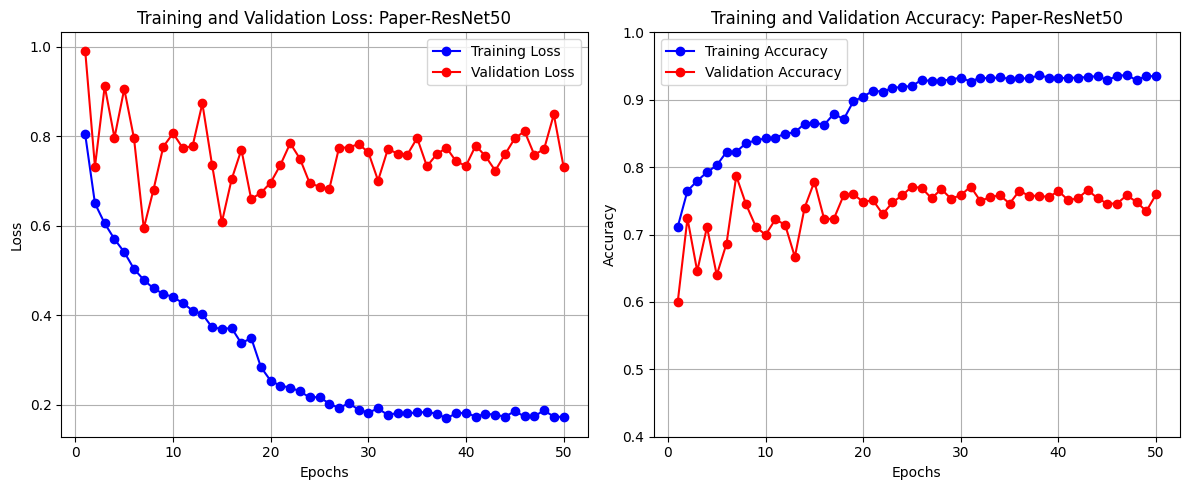

In [27]:
plot_history(resnet50_train_loss_hist, resnet50_val_loss_hist,
             resnet50_train_acc_hist, resnet50_net_val_acc_hist, 'Paper-ResNet50')

In [ ]:
%%time
## Training/Evaluating on validation set densenet

## set model to devide
densenet = densenet.to(device)

wandb.init(
      # Set the project where this run will be logged
      project="HAM_IMG_Classifier", 
      # We pass a run name
      name=f"base-densenet", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0001,
      "architecture": "Densenet",
      "dropout": 0.4,
      "dataset": "HAM10K",
      "epochs": epochs,
      "criterion": criterion,
      "weight decay" : 0.00001,
      "scheduler": "True"
      })

##small
#densenet_val_predictions, densenet_val_labels, densenet_train_loss_hist, densenet_val_loss_hist, densenet_train_acc_hist, densenet_val_acc_hist = train_loop(densenet, optimizer_densenet, scheduler_densenet, criterion, ds_train_small, ds_val, epochs, num_classes, 'densenet')
##full
densenet_val_predictions, densenet_val_labels, densenet_train_loss_hist, densenet_val_loss_hist, densenet_train_acc_hist, densenet_val_acc_hist = train_loop(densenet, optimizer_densenet, scheduler_densenet, criterion, ds_train, ds_val, epochs, num_classes, 'base_densenet')

# Mark the run as finished
wandb.finish()

wandb: Currently logged in as: pedrocast7 (projects-pedro-ml). Use `wandb login --relogin` to force relogin


Epoch 1/50


100%|██████████| 56/56 [00:13<00:00,  4.19it/s]


Training Loss: 0.8279, Train Accuracy: 0.7109, Train Normalized Accuracy: 0.2682
Validation Loss: 0.8049, Val Accuracy: 0.6837, Val Normalized Accuracy: 0.4858
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 2/50


100%|██████████| 56/56 [00:10<00:00,  5.35it/s]


Training Loss: 0.6324, Train Accuracy: 0.7742, Train Normalized Accuracy: 0.4912
Validation Loss: 0.7435, Val Accuracy: 0.7263, Val Normalized Accuracy: 0.5124
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 3/50


100%|██████████| 56/56 [00:10<00:00,  5.26it/s]


Training Loss: 0.5549, Train Accuracy: 0.8045, Train Normalized Accuracy: 0.5542
Validation Loss: 0.6616, Val Accuracy: 0.7644, Val Normalized Accuracy: 0.6158
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 4/50


100%|██████████| 56/56 [00:10<00:00,  5.34it/s]


Training Loss: 0.5149, Train Accuracy: 0.8136, Train Normalized Accuracy: 0.6074
Validation Loss: 0.6535, Val Accuracy: 0.7594, Val Normalized Accuracy: 0.6699
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 5/50


100%|██████████| 56/56 [00:11<00:00,  4.93it/s]


Training Loss: 0.4700, Train Accuracy: 0.8307, Train Normalized Accuracy: 0.6461
Validation Loss: 0.6978, Val Accuracy: 0.7353, Val Normalized Accuracy: 0.6257
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 6/50


100%|██████████| 56/56 [00:10<00:00,  5.26it/s]


Training Loss: 0.4454, Train Accuracy: 0.8373, Train Normalized Accuracy: 0.6887
Validation Loss: 0.6642, Val Accuracy: 0.7493, Val Normalized Accuracy: 0.6334
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 7/50


100%|██████████| 56/56 [00:10<00:00,  5.31it/s]


Training Loss: 0.4303, Train Accuracy: 0.8383, Train Normalized Accuracy: 0.6965
Validation Loss: 0.6948, Val Accuracy: 0.7431, Val Normalized Accuracy: 0.6806
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 8/50


100%|██████████| 56/56 [00:10<00:00,  5.21it/s]


Training Loss: 0.4012, Train Accuracy: 0.8501, Train Normalized Accuracy: 0.7213
Validation Loss: 0.7655, Val Accuracy: 0.7179, Val Normalized Accuracy: 0.6980
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 9/50


100%|██████████| 56/56 [00:10<00:00,  5.28it/s]


Training Loss: 0.3674, Train Accuracy: 0.8621, Train Normalized Accuracy: 0.7406
Validation Loss: 0.6793, Val Accuracy: 0.7560, Val Normalized Accuracy: 0.6852
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 10/50


100%|██████████| 56/56 [00:11<00:00,  5.05it/s]


Training Loss: 0.3553, Train Accuracy: 0.8666, Train Normalized Accuracy: 0.7592
Validation Loss: 0.6504, Val Accuracy: 0.7723, Val Normalized Accuracy: 0.7002
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 11/50


100%|██████████| 56/56 [00:10<00:00,  5.11it/s]


Training Loss: 0.3321, Train Accuracy: 0.8762, Train Normalized Accuracy: 0.7743
Validation Loss: 0.6926, Val Accuracy: 0.7493, Val Normalized Accuracy: 0.7024
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 12/50


100%|██████████| 56/56 [00:10<00:00,  5.41it/s]


Training Loss: 0.3251, Train Accuracy: 0.8753, Train Normalized Accuracy: 0.7824
Validation Loss: 0.6653, Val Accuracy: 0.7622, Val Normalized Accuracy: 0.6846
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 13/50


100%|██████████| 56/56 [00:10<00:00,  5.35it/s]


Training Loss: 0.3066, Train Accuracy: 0.8808, Train Normalized Accuracy: 0.7889
Validation Loss: 0.8226, Val Accuracy: 0.7022, Val Normalized Accuracy: 0.7025
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 14/50


100%|██████████| 56/56 [00:10<00:00,  5.38it/s]


Training Loss: 0.2826, Train Accuracy: 0.8958, Train Normalized Accuracy: 0.8279
Validation Loss: 0.7145, Val Accuracy: 0.7465, Val Normalized Accuracy: 0.6790
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 15/50


100%|██████████| 56/56 [00:10<00:00,  5.35it/s]


Training Loss: 0.2906, Train Accuracy: 0.8914, Train Normalized Accuracy: 0.8100
Validation Loss: 0.7051, Val Accuracy: 0.7740, Val Normalized Accuracy: 0.6956
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 16/50


100%|██████████| 56/56 [00:11<00:00,  4.86it/s]


Training Loss: 0.2674, Train Accuracy: 0.9039, Train Normalized Accuracy: 0.8398
Validation Loss: 0.6298, Val Accuracy: 0.7846, Val Normalized Accuracy: 0.7185
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 17/50


100%|██████████| 56/56 [00:10<00:00,  5.39it/s]


Training Loss: 0.2569, Train Accuracy: 0.9066, Train Normalized Accuracy: 0.8450
Validation Loss: 0.6545, Val Accuracy: 0.7858, Val Normalized Accuracy: 0.6768
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 18/50


100%|██████████| 56/56 [00:10<00:00,  5.51it/s]


Training Loss: 0.2367, Train Accuracy: 0.9119, Train Normalized Accuracy: 0.8456
Validation Loss: 0.8048, Val Accuracy: 0.7420, Val Normalized Accuracy: 0.7092
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 19/50


100%|██████████| 56/56 [00:10<00:00,  5.44it/s]


Training Loss: 0.2347, Train Accuracy: 0.9147, Train Normalized Accuracy: 0.8577
Validation Loss: 0.7911, Val Accuracy: 0.7616, Val Normalized Accuracy: 0.7138
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 20/50


100%|██████████| 56/56 [00:10<00:00,  5.24it/s]


Training Loss: 0.2282, Train Accuracy: 0.9184, Train Normalized Accuracy: 0.8670
Validation Loss: 0.6800, Val Accuracy: 0.7841, Val Normalized Accuracy: 0.6942
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 21/50


100%|██████████| 56/56 [00:11<00:00,  5.00it/s]


Training Loss: 0.2211, Train Accuracy: 0.9215, Train Normalized Accuracy: 0.8634
Validation Loss: 0.6838, Val Accuracy: 0.7880, Val Normalized Accuracy: 0.6797
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 22/50


100%|██████████| 56/56 [00:10<00:00,  5.19it/s]


Training Loss: 0.2153, Train Accuracy: 0.9213, Train Normalized Accuracy: 0.8638
Validation Loss: 0.7289, Val Accuracy: 0.7773, Val Normalized Accuracy: 0.7193
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 23/50


100%|██████████| 56/56 [00:10<00:00,  5.22it/s]


Training Loss: 0.1924, Train Accuracy: 0.9309, Train Normalized Accuracy: 0.8820
Validation Loss: 0.6519, Val Accuracy: 0.8087, Val Normalized Accuracy: 0.6621
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 24/50


100%|██████████| 56/56 [00:10<00:00,  5.36it/s]


Training Loss: 0.1868, Train Accuracy: 0.9309, Train Normalized Accuracy: 0.8828
Validation Loss: 0.6890, Val Accuracy: 0.8003, Val Normalized Accuracy: 0.7237
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 25/50


100%|██████████| 56/56 [00:10<00:00,  5.36it/s]


Training Loss: 0.1947, Train Accuracy: 0.9282, Train Normalized Accuracy: 0.8877
Validation Loss: 0.6797, Val Accuracy: 0.7964, Val Normalized Accuracy: 0.7406
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 26/50


100%|██████████| 56/56 [00:10<00:00,  5.22it/s]


Training Loss: 0.1993, Train Accuracy: 0.9293, Train Normalized Accuracy: 0.8847
Validation Loss: 0.6688, Val Accuracy: 0.8093, Val Normalized Accuracy: 0.7147
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 27/50


100%|██████████| 56/56 [00:10<00:00,  5.17it/s]


Training Loss: 0.1673, Train Accuracy: 0.9405, Train Normalized Accuracy: 0.9038
Validation Loss: 0.6719, Val Accuracy: 0.8172, Val Normalized Accuracy: 0.7518
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 28/50


100%|██████████| 56/56 [00:10<00:00,  5.33it/s]


Training Loss: 0.1776, Train Accuracy: 0.9359, Train Normalized Accuracy: 0.8933
Validation Loss: 0.6852, Val Accuracy: 0.8110, Val Normalized Accuracy: 0.7488
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 29/50


100%|██████████| 56/56 [00:10<00:00,  5.36it/s]


Training Loss: 0.1547, Train Accuracy: 0.9446, Train Normalized Accuracy: 0.9211
Validation Loss: 0.7857, Val Accuracy: 0.7914, Val Normalized Accuracy: 0.7417
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 30/50


100%|██████████| 56/56 [00:10<00:00,  5.30it/s]


Training Loss: 0.1653, Train Accuracy: 0.9404, Train Normalized Accuracy: 0.8950
Validation Loss: 0.6702, Val Accuracy: 0.8003, Val Normalized Accuracy: 0.7440
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 31/50


100%|██████████| 56/56 [00:10<00:00,  5.34it/s]


Training Loss: 0.1511, Train Accuracy: 0.9454, Train Normalized Accuracy: 0.9131
Validation Loss: 0.7768, Val Accuracy: 0.7852, Val Normalized Accuracy: 0.7486
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 32/50


100%|██████████| 56/56 [00:11<00:00,  5.04it/s]


Training Loss: 0.1332, Train Accuracy: 0.9540, Train Normalized Accuracy: 0.9308
Validation Loss: 0.7167, Val Accuracy: 0.8289, Val Normalized Accuracy: 0.7551
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 33/50


100%|██████████| 56/56 [00:10<00:00,  5.36it/s]


Training Loss: 0.1517, Train Accuracy: 0.9466, Train Normalized Accuracy: 0.9110
Validation Loss: 0.7087, Val Accuracy: 0.8245, Val Normalized Accuracy: 0.7366
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 34/50


100%|██████████| 56/56 [00:10<00:00,  5.43it/s]


Training Loss: 0.1408, Train Accuracy: 0.9478, Train Normalized Accuracy: 0.9128
Validation Loss: 0.7660, Val Accuracy: 0.7841, Val Normalized Accuracy: 0.7546
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 35/50


100%|██████████| 56/56 [00:10<00:00,  5.25it/s]


Training Loss: 0.1412, Train Accuracy: 0.9487, Train Normalized Accuracy: 0.9159
Validation Loss: 0.8306, Val Accuracy: 0.7824, Val Normalized Accuracy: 0.7329
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 36/50


100%|██████████| 56/56 [00:10<00:00,  5.31it/s]


Training Loss: 0.1349, Train Accuracy: 0.9508, Train Normalized Accuracy: 0.9135
Validation Loss: 0.7576, Val Accuracy: 0.8093, Val Normalized Accuracy: 0.7316
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 37/50


100%|██████████| 56/56 [00:10<00:00,  5.25it/s]


Training Loss: 0.1379, Train Accuracy: 0.9495, Train Normalized Accuracy: 0.9156
Validation Loss: 0.7667, Val Accuracy: 0.8020, Val Normalized Accuracy: 0.7339
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 38/50


100%|██████████| 56/56 [00:10<00:00,  5.32it/s]


Training Loss: 0.1342, Train Accuracy: 0.9520, Train Normalized Accuracy: 0.9190
Validation Loss: 0.8282, Val Accuracy: 0.7790, Val Normalized Accuracy: 0.7258
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 39/50


100%|██████████| 56/56 [00:10<00:00,  5.33it/s]


Training Loss: 0.1241, Train Accuracy: 0.9571, Train Normalized Accuracy: 0.9285
Validation Loss: 0.7768, Val Accuracy: 0.7953, Val Normalized Accuracy: 0.7343
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 40/50


100%|██████████| 56/56 [00:10<00:00,  5.49it/s]


Training Loss: 0.1316, Train Accuracy: 0.9567, Train Normalized Accuracy: 0.9339
Validation Loss: 0.8918, Val Accuracy: 0.7891, Val Normalized Accuracy: 0.7359
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 41/50


100%|██████████| 56/56 [00:10<00:00,  5.42it/s]


Training Loss: 0.1173, Train Accuracy: 0.9599, Train Normalized Accuracy: 0.9383
Validation Loss: 0.8401, Val Accuracy: 0.7891, Val Normalized Accuracy: 0.7345
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 42/50


100%|██████████| 56/56 [00:10<00:00,  5.40it/s]


Training Loss: 0.1106, Train Accuracy: 0.9602, Train Normalized Accuracy: 0.9344
Validation Loss: 0.7243, Val Accuracy: 0.8188, Val Normalized Accuracy: 0.7492
Learning Rate Value: 0.0001
----------------------------------------------------------------------------------------------------
Epoch 43/50


 64%|██████▍   | 36/56 [00:06<00:03,  5.61it/s]

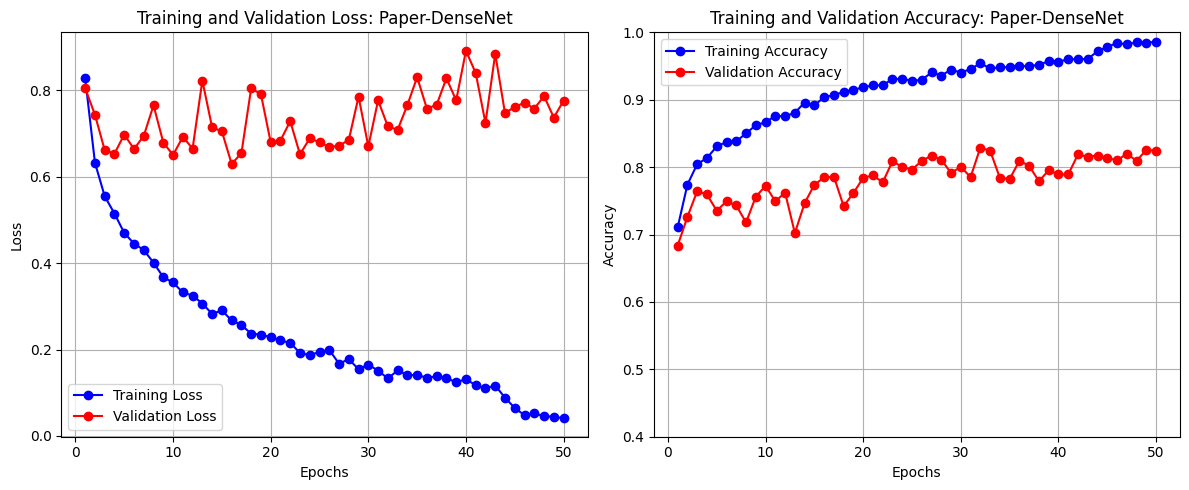

In [26]:
plot_history(densenet_train_loss_hist, densenet_val_loss_hist,
             densenet_train_acc_hist, densenet_val_acc_hist, 'Paper-DenseNet')

In [28]:
## Seeing the other metrics

print('VGG-16:')

precision, recall, f1, roc_auc = calculate_other_metrics(vgg16_val_predictions, vgg16_val_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}\n")

print('ResNet50:')
precision, recall, f1, roc_auc = calculate_other_metrics(resnet50_val_predictions, resnet50_val_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}\n")

print('Densenet:')
precision, recall, f1, roc_auc = calculate_other_metrics(densenet_val_predictions, densenet_val_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}")

VGG-16:
Weighted Precision: 0.8145, Weighted Recall: 0.7858, Weighted F1: 0.7959, Avg-AUC: 0.8303

ResNet50:
Weighted Precision: 0.8053, Weighted Recall: 0.7594, Weighted F1: 0.7752, Avg-AUC: 0.8331

Densenet:
Weighted Precision: 0.8315, Weighted Recall: 0.8245, Weighted F1: 0.8269, Avg-AUC: 0.8503


#### The models achieved relatively good results after tunning the hyperparameters, but needing more epochs to converge than the paper cited (needed 50 epochs while the paper stops the training after 30). Also, the learning rate for the DenseNet model was different than the used there (0.001). Instead, using the same value of the other models increased its validation accuracy. Their performances on the validation set shows that the DenseNet is the best model, according to the accuracy obtained (about 82%), followed by the VGG16, with 80%. The other metrics also reforces this pattern. With the hyperparameters tunned, we now need to test the models over a test set to see how it will perform on a real scenario.

### **4 - Models' Results**

##### **4.1 - Evaluation on Test Data**

In [32]:
## Evaluating the model's performances on the ds_test set

## Vgg16
## Loading model with best accuracy
vgg16.load_state_dict(torch.load('/kaggle/working/models/base_vgg16_best_acc.pth'))
vgg16.to(device)

vgg16_test_loss, vgg16_test_accuracy, vgg16_test_normalized_accuracy, vgg16_test_predictions, vgg16_test_labels = evaluate(vgg16, ds_test, criterion, num_classes)

print(f"Test Loss: {vgg16_test_loss:.4f}, Test Accuracy: {vgg16_test_accuracy:.4f}, Test Normalized Accuracy: {vgg16_test_normalized_accuracy:.4f}")

100%|██████████| 35/35 [01:27<00:00,  2.49s/it]

Test Loss: 0.7828, Test Accuracy: 0.7958, Test Normalized Accuracy: 0.6980


In [34]:
## ResNet50
## Loading model with best accuracy
resnet50.load_state_dict(torch.load('/kaggle/working/models/base_resnet50_best_acc.pth'))
resnet50.to(device)

resnet50_test_loss, resnet50_test_accuracy, resnet50_test_normalized_accuracy, resnet50_test_predictions, resnet50_test_labels = evaluate(resnet50, ds_test, criterion, num_classes)
print(f"Test Loss: {resnet50_test_loss:.4f}, Test Accuracy: {resnet50_test_accuracy:.4f}, Test Normalized Accuracy: {resnet50_test_normalized_accuracy:.4f}")

100%|██████████| 35/35 [00:06<00:00,  5.25it/s]

Test Loss: 0.6382, Test Accuracy: 0.7722, Test Normalized Accuracy: 0.5849


In [46]:
## DenseNet
## Loading model with best accuracy
densenet.load_state_dict(torch.load('/kaggle/working/models/base_densenet_best_acc.pth'))
densenet.to(device)

densenet_test_loss, densenet_test_accuracy, densenet_test_normalized_accuracy, densenet_test_predictions, densenet_test_labels = evaluate(densenet, ds_test, criterion, num_classes)
print(f"Test Loss: {densenet_test_loss:.4f}, Test Accuracy: {densenet_test_accuracy:.4f}, Test Normalized Accuracy: {densenet_test_normalized_accuracy:.4f}")

100%|██████████| 35/35 [00:06<00:00,  5.07it/s]

Test Loss: 0.7193, Test Accuracy: 0.8167, Test Normalized Accuracy: 0.6905


#### The test set performance for all models drops a little, but the results still consistent with the DenseNet taking the lead of the accuracy performance.

##### **4.2 - Confusion Matrix of the Models and other Metrics**

In [53]:
## Label for the numerical targets

unique_pairs = df_test.drop_duplicates(subset=['cell_type', 'cell_type_idx'])

unique_pairs[['cell_type', 'cell_type_idx']].sort_values(by='cell_type_idx').reset_index(drop=True)

,cell_type,cell_type_idx
0,Actinic keratoses,0
1,Basal cell carcinoma,1
2,Benign keratosis-like lesions,2
3,Dermatofibroma,3
4,Melanocytic nevi,4
5,Melanoma,5
6,Vascular lesions,6


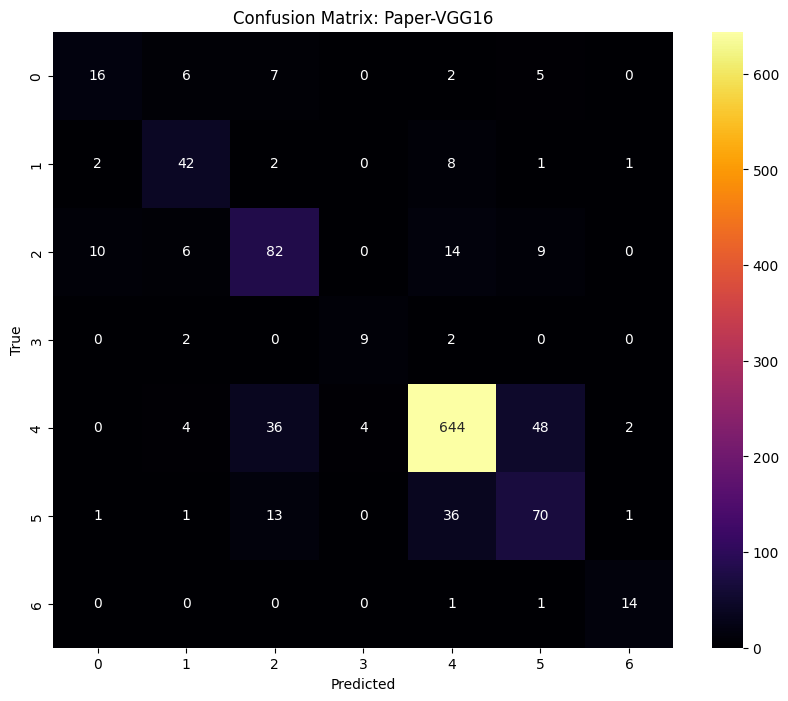

In [41]:
## VGG16

plot_confusion_matrix(vgg16_test_predictions, vgg16_test_labels, num_classes, 'Paper-VGG16')

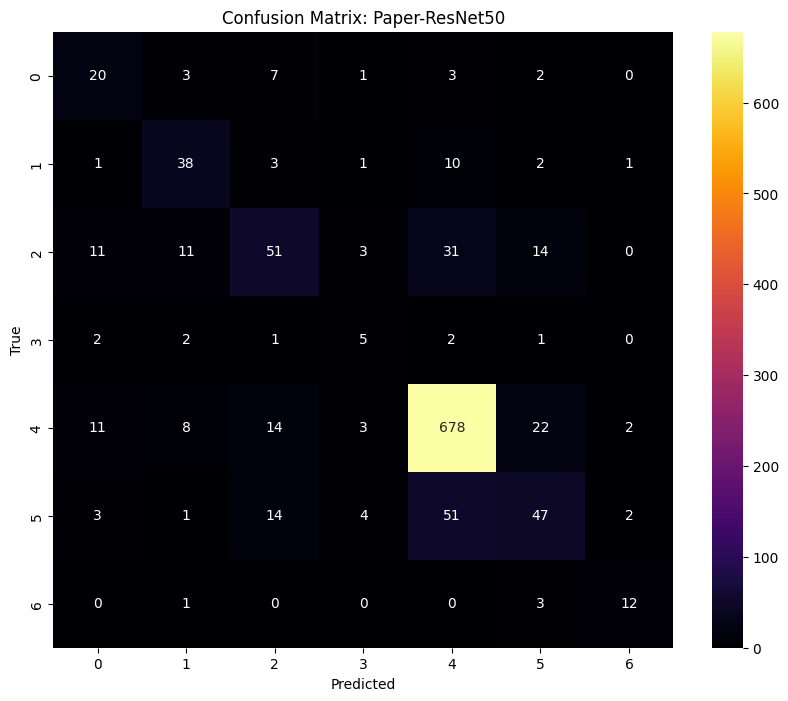

In [42]:
## ResNet50

plot_confusion_matrix(resnet50_test_predictions, resnet50_test_labels, num_classes, 'Paper-ResNet50')

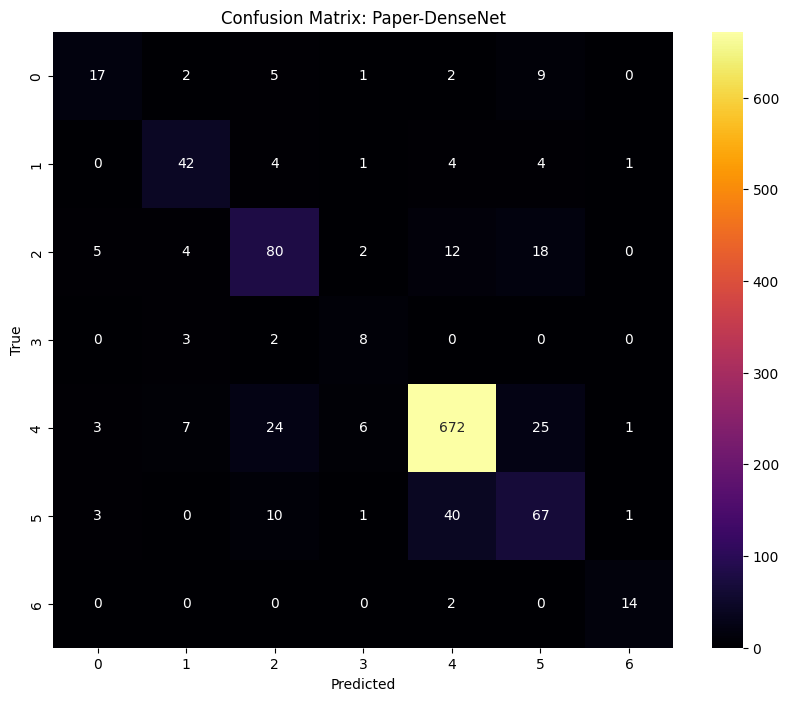

In [47]:
## DenseNet

plot_confusion_matrix(densenet_test_predictions, densenet_test_labels, num_classes, 'Paper-DenseNet')

In [48]:
## Seeing the other metrics

print('VGG-16:')

precision, recall, f1, roc_auc = calculate_other_metrics(vgg16_test_predictions, vgg16_test_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}\n")

print('ResNet50:')
precision, recall, f1, roc_auc = calculate_other_metrics(resnet50_test_predictions, resnet50_test_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}\n")

print('Densenet:')
precision, recall, f1, roc_auc = calculate_other_metrics(densenet_test_predictions, densenet_test_labels)
print(f"Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}, Weighted F1: {f1:.4f}, Avg-AUC: {roc_auc:.4f}")

VGG-16:
Weighted Precision: 0.8046, Weighted Recall: 0.7958, Weighted F1: 0.7992, Avg-AUC: 0.8250

ResNet50:
Weighted Precision: 0.7628, Weighted Recall: 0.7722, Weighted F1: 0.7644, Avg-AUC: 0.7626

Densenet:
Weighted Precision: 0.8189, Weighted Recall: 0.8167, Weighted F1: 0.8173, Avg-AUC: 0.8234


#### The metrics and the graphs show that, for the main and the auxiliary metrics suggested by the referred paper, all 3 models got pretty good results, being able to achieve values above 70% for all metrics. Nevertheless, those metrics are inflated, not ideal for cases of data with unbalanced classes. With this in mind, an approach taking into account metrics such as balanced accuracy and normalized accuracy is necessary, adjusting the hyperparameters in order to maximize performance in these new metrics.